# Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

# Reading df

In [3]:
df = pd.read_pickle('EasyMoney_1.pkl', compression='zip')

In [4]:
df.head() # verifying df

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,region_name,salary_categ,dif_loans,dif_mortgage,dif_funds,dif_securities,dif_long_term_deposit,dif_em_account_pp,dif_credit_card,dif_payroll,dif_pension_plan,dif_payroll_account,dif_emc_account,dif_debit_card,dif_em_account_p,dif_em_acount,dif_short_term_deposit,meses_alta,new_client,productos_totales,ingresos_producto,suma_productos_totales,cliente_activo,cuenta,ahorro_inversion,financiacion
0,15891,2018-07-28,2018-07-28,KAT,1,desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,28.0,H,59,0,-999.0,Madrid,unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,1,0.0,1,1,0,0,0
1,15891,2018-08-28,2018-07-28,KAT,0,particulares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,H,59,0,-999.0,Madrid,unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1.000000,0,0,0.0,1,1,-1,0,0
2,16063,2018-11-28,2018-11-19,KAT,1,desconocido,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,H,62,0,-999.0,Madrid,unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.290323,1,0,0.0,0,0,0,0,0
3,16063,2018-12-28,2018-11-19,KAT,1,particulares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,H,62,0,-999.0,Madrid,unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.258065,0,0,0.0,0,0,0,0,0
4,16063,2019-01-28,2018-11-19,KAT,1,particulares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ES,28.0,H,62,0,-999.0,Madrid,unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.258065,0,0,0.0,0,0,0,0,0


Since we want to predict the highs for the month of June, we'll need to take as variables those from the immediately preceding month. That is, to predict June, we'll use the variables of that client from the month of May.

In [5]:
vars_colums=['pk_cid','pk_partition',
'entry_date',             
'entry_channel',                 
'active_customer',              
'segment',                     
'country_id',                  
'region_code',                  
'gender',                         
'age',                            
'deceased',              
'salary', 
'debit_card', 
'meses_alta',                   
'new_client',                    
'productos_totales',
'ingresos_producto',
'cliente_activo']

In [6]:
delta_productos_easymoney=['dif_debit_card']

In [7]:
df_altas=df.melt(id_vars=vars_colums,
            value_vars=delta_productos_easymoney,
            var_name='Product',
            value_name='Count')

In [8]:
df_altas.isnull().sum()

pk_cid               0
pk_partition         0
entry_date           0
entry_channel        0
active_customer      0
segment              0
country_id           0
region_code          0
gender               0
age                  0
deceased             0
salary               0
debit_card           0
meses_alta           0
new_client           0
productos_totales    0
ingresos_producto    0
cliente_activo       0
Product              0
Count                0
dtype: int64

# MultiIndex format

The current format of my dataframe is too large, and it doesn't allow me to track the evolution of a specific product for each customer on every date. Therefore, I need to use a multi-index format. To achieve this, I need to create a list with the dates (including the month to predict, which will have null values), the active customers in the last month, and the product to predict. Due to kernel memory limitations, I'll create as many models as products to predict, changing the product differential to analyze.

In [9]:
fechas=['2018-01-28',
'2018-02-28',
'2018-03-28',
'2018-04-28',
'2018-05-28',
'2018-06-28',
'2018-07-28',
'2018-08-28',
'2018-09-28',
'2018-10-28',
'2018-11-28',
'2018-12-28',
'2019-01-28',
'2019-02-28',
'2019-03-28',
'2019-04-28',
'2019-05-28',             
'2019-06-28'] # including month we're trying to predict

In [10]:
# filtering since we want to use only active customers in May (last month)
clientes=df_altas[(df_altas['cliente_activo']==1) & 
                        (df_altas['pk_partition']=='2019-05-28')]["pk_cid"].unique().tolist()



In [11]:
len(clientes)
#this will be the register number by date (we'll verify this later -> check *)

344704

In [12]:
producto_pred=['dif_debit_card'] # CHANGE FOR WHATEVER PRODUCT IS WISHED TO PREDICT

In [13]:
df_multi = pd.MultiIndex.from_product([fechas, clientes, producto_pred], 
                                      names = ["pk_partition", "pk_cid", "Product"])
len(df_multi)

6204672

In [14]:
df_multi

MultiIndex([('2018-01-28',   16203, 'dif_debit_card'),
            ('2018-01-28',   16502, 'dif_debit_card'),
            ('2018-01-28',   17457, 'dif_debit_card'),
            ('2018-01-28',   17799, 'dif_debit_card'),
            ('2018-01-28',   17970, 'dif_debit_card'),
            ('2018-01-28',   17980, 'dif_debit_card'),
            ('2018-01-28',   18146, 'dif_debit_card'),
            ('2018-01-28',   18704, 'dif_debit_card'),
            ('2018-01-28',   19021, 'dif_debit_card'),
            ('2018-01-28',   19268, 'dif_debit_card'),
            ...
            ('2019-06-28', 1553390, 'dif_debit_card'),
            ('2019-06-28', 1553393, 'dif_debit_card'),
            ('2019-06-28', 1553415, 'dif_debit_card'),
            ('2019-06-28', 1553429, 'dif_debit_card'),
            ('2019-06-28', 1553436, 'dif_debit_card'),
            ('2019-06-28', 1553456, 'dif_debit_card'),
            ('2019-06-28', 1553541, 'dif_debit_card'),
            ('2019-06-28', 1553559, 'dif_debit_ca

In [15]:
full_df = pd.DataFrame(index = df_multi).reset_index()
full_df.tail()

,pk_partition,pk_cid,Product
6204667,2019-06-28,1553456,dif_debit_card
6204668,2019-06-28,1553541,dif_debit_card
6204669,2019-06-28,1553559,dif_debit_card
6204670,2019-06-28,1553565,dif_debit_card
6204671,2019-06-28,1553571,dif_debit_card


In [16]:
# fomatting pk_partition variable as date 
full_df['pk_partition']=pd.to_datetime(full_df['pk_partition'], format='%Y-%m-%d')

In [17]:
full_df.groupby('pk_partition')['pk_cid'].size()
# verifying the registrations number each date is the same than in * above - well done

pk_partition
2018-01-28    344704
2018-02-28    344704
2018-03-28    344704
2018-04-28    344704
2018-05-28    344704
2018-06-28    344704
2018-07-28    344704
2018-08-28    344704
2018-09-28    344704
2018-10-28    344704
2018-11-28    344704
2018-12-28    344704
2019-01-28    344704
2019-02-28    344704
2019-03-28    344704
2019-04-28    344704
2019-05-28    344704
2019-06-28    344704
Name: pk_cid, dtype: int64

In [18]:
full_df = pd.merge(full_df, df_altas, on = ["pk_partition", "pk_cid", "Product"], how = 'left')
#performing a left merge to keep df with specific product (in this case, debit card) 

In [19]:
full_df.head()

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,debit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count
0,2018-01-28,16203,dif_debit_card,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-28,16502,dif_debit_card,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-28,17457,dif_debit_card,2017-09-16,KAT,1.0,particulares,ES,28.0,H,53.0,0.0,102405.75,0.0,4.322581,0.0,2.0,0.0,1.0,0.0
3,2018-01-28,17799,dif_debit_card,2018-01-04,KAT,1.0,particulares,ES,28.0,H,46.0,0.0,84511.86,0.0,0.774194,1.0,1.0,10.0,1.0,0.0
4,2018-01-28,17970,dif_debit_card,2015-04-16,KAT,1.0,particulares,ES,28.0,V,75.0,0.0,-999.00,1.0,32.838710,0.0,4.0,0.0,1.0,0.0


In [20]:
del df_altas
del df

In [21]:
full_df.isna().sum() # since we're creating so many made up registrations, when merging we get multiple nulls

pk_partition               0
pk_cid                     0
Product                    0
entry_date           1259563
entry_channel        1259563
active_customer      1259563
segment              1259563
country_id           1259563
region_code          1259563
gender               1259563
age                  1259563
deceased             1259563
salary               1259563
debit_card           1259563
meses_alta           1259563
new_client           1259563
productos_totales    1259563
ingresos_producto    1259563
cliente_activo       1259563
Count                1259563
dtype: int64

In [22]:
full_df.shape #aprox 1/6 nulls

(6204672, 20)

In [23]:
full_df.drop (full_df[ (full_df['pk_partition']!='2019-06-28') &
                    (full_df['entry_date'].isnull()) ].index, axis=0, inplace=True)

In [24]:
# verifying we dropped them all
full_df.groupby('pk_partition')['pk_cid'].size()

pk_partition
2018-01-28    233491
2018-02-28    236751
2018-03-28    239374
2018-04-28    241487
2018-05-28    243824
2018-06-28    245905
2018-07-28    265666
2018-08-28    277576
2018-09-28    296059
2018-10-28    314142
2018-11-28    324099
2018-12-28    328275
2019-01-28    333082
2019-02-28    337077
2019-03-28    340520
2019-04-28    343077
2019-05-28    344704
2019-06-28    344704
Name: pk_cid, dtype: int64

In [25]:
full_df.shape #makes sense, since we dropped 1 mil -> 5mil left

(5289813, 20)

In [26]:
full_df.head()

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,debit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count
2,2018-01-28,17457,dif_debit_card,2017-09-16,KAT,1.0,particulares,ES,28.0,H,53.0,0.0,102405.75,0.0,4.322581,0.0,2.0,0.0,1.0,0.0
3,2018-01-28,17799,dif_debit_card,2018-01-04,KAT,1.0,particulares,ES,28.0,H,46.0,0.0,84511.86,0.0,0.774194,1.0,1.0,10.0,1.0,0.0
4,2018-01-28,17970,dif_debit_card,2015-04-16,KAT,1.0,particulares,ES,28.0,V,75.0,0.0,-999.00,1.0,32.838710,0.0,4.0,0.0,1.0,0.0
7,2018-01-28,18704,dif_debit_card,2017-01-20,KAT,1.0,particulares,ES,41.0,H,55.0,0.0,75187.44,0.0,12.032258,0.0,1.0,0.0,1.0,0.0
8,2018-01-28,19021,dif_debit_card,2016-10-11,KAT,1.0,particulares,ES,28.0,V,63.0,0.0,129492.36,0.0,15.290323,0.0,1.0,0.0,1.0,0.0


In [27]:
# We want to predict the null values (corresponding to the month of June) of the em account,
# so we need to fill in the features that we do know (for example, age, salary...).
variables_conocidas =['entry_date',
                    'entry_channel',
                    'active_customer',
                    'segment',
                    'country_id',
                    'region_code',
                    'gender',
                    'age',
                    'deceased',
                    'salary']

In [28]:
# creating a loop to fill them 
for x in variables_conocidas:
    print(x)
    # obtaining col x value for previous month (may 2019)
    valor_anterior = full_df.loc[full_df['pk_partition'] == '2019-05-28', x]
    # assigning previous month's value to alast month's wors (June 2019)
    full_df.loc[full_df['pk_partition'] == '2019-06-28', x] = valor_anterior.values

entry_date
entry_channel
active_customer


segment
country_id
region_code
gender
age
deceased
salary


In [29]:
full_df[(full_df['pk_cid']==1231342) & (full_df['pk_partition']=='2019-06-28')]

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,debit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count
6012595,2019-06-28,1231342,dif_debit_card,2016-12-13,KHE,1.0,universitario,ES,4.0,V,22.0,0.0,72759.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# verifying we only have nulls for 1 month (june) + variables we have not filled 
full_df.isnull().sum()

pk_partition              0
pk_cid                    0
Product                   0
entry_date                0
entry_channel             0
active_customer           0
segment                   0
country_id                0
region_code               0
gender                    0
age                       0
deceased                  0
salary                    0
debit_card           344704
meses_alta           344704
new_client           344704
productos_totales    344704
ingresos_producto    344704
cliente_activo       344704
Count                344704
dtype: int64

Filling in those variables with information from the same date would skew the model, as they are variables that we only have information about if we know the products that the client maintains or subscribes to in that same month. Therefore, the only option is to create variables for the immediately preceding values and hope that they provide information to the model for prediction. For example, if we want to predict whether a client will demand a product in May, we'll use the value from April for how much income the client provides.

In [31]:
# lets use 5 months as lag
for x in [1,2,3,4,5]:
    full_df['debit_card_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['debit_card'].shift(x)
    full_df['meses_alta_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['meses_alta'].shift(x)
    full_df['new_client_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['new_client'].shift(x)
    full_df['productos_totales_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['productos_totales'].shift(x)
    full_df['ingresos_producto_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['ingresos_producto'].shift(x)
    full_df['cliente_activo_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['cliente_activo'].shift(x)
    full_df['Count_shift_'+str(x)]=full_df.groupby(['pk_cid','Product'])['Count'].shift(x)

In [32]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5289813 entries, 2 to 6204671
Data columns (total 55 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   pk_partition               datetime64[ns]
 1   pk_cid                     int64         
 2   Product                    object        
 3   entry_date                 datetime64[ns]
 4   entry_channel              category      
 5   active_customer            float64       
 6   segment                    category      
 7   country_id                 category      
 8   region_code                category      
 9   gender                     category      
 10  age                        float64       
 11  deceased                   float64       
 12  salary                     float64       
 13  debit_card                 float64       
 14  meses_alta                 float64       
 15  new_client                 float64       
 16  productos_totales          float64       

# Variable pre-processing


Before training the model, I need to prepare the variables. Specifically:

* Transform the dates to extract useful information (e.g., month or year). In this case, the day of the week doesn't provide relevant information because data is always collected on the 28th of each month.
* Apply One-Hot Encoding to categorical variables such as gender, entry_channel, segment, region_code, and gender.
* Remove the variable country_id - we observed that the majority of data comes from Spain, so performing One-Hot Encoding on this variable could increase the computational demand of the model without providing much information.

In [33]:
# Step 1 - dates
full_df["year"] = full_df["pk_partition"].dt.year
full_df["month"] = full_df["pk_partition"].dt.month

full_df["entry_date_year"] = full_df["entry_date"].dt.year
full_df["entry_date_month"] = full_df["entry_date"].dt.month

In [34]:
# Step 2 - OHE
dummy_genero = pd.get_dummies(full_df['gender'],prefix='gender')
dummy_entry_channel = pd.get_dummies(full_df['entry_channel'],prefix='entry_channel')
dummy_segment = pd.get_dummies(full_df['segment'],prefix='segment')
dummy_region_code = pd.get_dummies(full_df['region_code'],prefix='region_code')

In [35]:
datasets = [dummy_genero, dummy_entry_channel, dummy_segment, dummy_region_code]

for dataset in datasets:
    full_df = pd.concat([full_df, dataset], axis=1)

In [36]:
for x in datasets:
    del x

In [37]:
# Step 3 - Country Id - dropping later on

In [38]:
full_df

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,debit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count,debit_card_shift_1,meses_alta_shift_1,new_client_shift_1,productos_totales_shift_1,ingresos_producto_shift_1,cliente_activo_shift_1,Count_shift_1,debit_card_shift_2,meses_alta_shift_2,new_client_shift_2,productos_totales_shift_2,ingresos_producto_shift_2,cliente_activo_shift_2,Count_shift_2,debit_card_shift_3,meses_alta_shift_3,new_client_shift_3,productos_totales_shift_3,ingresos_producto_shift_3,cliente_activo_shift_3,Count_shift_3,debit_card_shift_4,meses_alta_shift_4,new_client_shift_4,productos_totales_shift_4,ingresos_producto_shift_4,cliente_activo_shift_4,Count_shift_4,debit_card_shift_5,meses_alta_shift_5,new_client_shift_5,productos_totales_shift_5,ingresos_producto_shift_5,cliente_activo_shift_5,Count_shift_5,year,month,entry_date_year,entry_date_month,gender_H,gender_V,gender_unknown,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,entry_channel_KAB,entry_channel_KAD,entry_channel_KAE,entry_channel_KAF,entry_channel_KAG,entry_channel_KAH,entry_channel_KAI,entry_channel_KAJ,entry_channel_KAK,entry_channel_KAM,entry_channel_KAQ,entry_channel_KAR,entry_channel_KAS,entry_channel_KAT,entry_channel_KAW,entry_channel_KAY,entry_channel_KAZ,entry_channel_KBE,entry_channel_KBG,entry_channel_KBH,entry_channel_KBO,entry_channel_KBU,entry_channel_KBW,entry_channel_KBY,entry_channel_KBZ,entry_channel_KCB,entry_channel_KCC,entry_channel_KCH,entry_channel_KCI,entry_channel_KCK,entry_channel_KCL,entry_channel_KDA,entry_channel_KDH,entry_channel_KDR,entry_channel_KDS,entry_channel_KDT,entry_channel_KEH,entry_channel_KEJ,entry_channel_KES,entry_channel_KEY,entry_channel_KFA,entry_channel_KFC,entry_channel_KFD,entry_channel_KFF,entry_channel_KFK,entry_channel_KFL,entry_channel_KFP,entry_channel_KFS,entry_channel_KGC,entry_channel_KGN,entry_channel_KGX,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHP,entry_channel_KHQ,entry_channel_KHS,entry_channel_RED,entry_channel_UNKNOWN,segment_desconocido,segment_particulares,segment_top,segment_universitario,region_code_1.0,region_code_2.0,region_code_3.0,region_code_4.0,region_code_5.0,region_code_6.0,region_code_7.0,region_code_8.0,region_code_9.0,region_code_10.0,region_code_11.0,region_code_12.0,region_code_13.0,region_code_14.0,region_code_15.0,region_code_16.0,region_code_17.0,region_code_18.0,region_code_19.0,region_code_20.0,region_code_21.0,region_code_22.0,region_code_23.0,region_code_24.0,region_code_25.0,region_code_26.0,region_code_27.0,region_code_28.0,region_code_29.0,region_code_30.0,region_code_31.0,region_code_32.0,region_code_33.0,region_code_34.0,region_code_35.0,region_code_36.0,region_code_37.0,region_code_38.0,region_code_39.0,region_code_40.0,region_code_41.0,region_code_42.0,region_code_43.0,region_code_44.0,region_code_45.0,region_code_46.0,region_code_47.0,region_code_48.0,region_code_49.0,region_code_50.0,region_code_51.0,region_code_52.0,region_code_999.0
2,2018-01-28,17457,dif_debit_card,2017-09-16,KAT,1.0,particulares,ES,28.0,H,53.0,0.0,102405.75,0.0,4.322581,0.0,2.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,1,2017,9,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,Fa

Mi dataset is going to have nulls in the 1st months (due to getting lags).

In [39]:
full_df.iloc[:,13:55].isna().sum()

debit_card                    344704
meses_alta                    344704
new_client                    344704
productos_totales             344704
ingresos_producto             344704
cliente_activo                344704
Count                         344704
debit_card_shift_1            344704
meses_alta_shift_1            344704
new_client_shift_1            344704
productos_totales_shift_1     344704
ingresos_producto_shift_1     344704
cliente_activo_shift_1        344704
Count_shift_1                 344704
debit_card_shift_2            689408
meses_alta_shift_2            689408
new_client_shift_2            689408
productos_totales_shift_2     689408
ingresos_producto_shift_2     689408
cliente_activo_shift_2        689408
Count_shift_2                 689408
debit_card_shift_3           1032516
meses_alta_shift_3           1032516
new_client_shift_3           1032516
productos_totales_shift_3    1032516
ingresos_producto_shift_3    1032516
cliente_activo_shift_3       1032516
C

To fill nulls, I'm going to divide the dataset in 3 and concatenate them, because if I don't I will encounter problems with categorical varaibles. 

In [40]:
nuevo_df = full_df.iloc[:, 13:55].fillna(-999)
antes_df = full_df.iloc[:, :13]
despues_df = full_df.iloc[:, 55:]

In [41]:
df = pd.concat([antes_df, nuevo_df, despues_df], axis=1)

In [42]:
# verifying there are no nulls
df.isna().sum().any()

False

In [43]:
df.head()

,pk_partition,pk_cid,Product,entry_date,entry_channel,active_customer,segment,country_id,region_code,gender,age,deceased,salary,debit_card,meses_alta,new_client,productos_totales,ingresos_producto,cliente_activo,Count,debit_card_shift_1,meses_alta_shift_1,new_client_shift_1,productos_totales_shift_1,ingresos_producto_shift_1,cliente_activo_shift_1,Count_shift_1,debit_card_shift_2,meses_alta_shift_2,new_client_shift_2,productos_totales_shift_2,ingresos_producto_shift_2,cliente_activo_shift_2,Count_shift_2,debit_card_shift_3,meses_alta_shift_3,new_client_shift_3,productos_totales_shift_3,ingresos_producto_shift_3,cliente_activo_shift_3,Count_shift_3,debit_card_shift_4,meses_alta_shift_4,new_client_shift_4,productos_totales_shift_4,ingresos_producto_shift_4,cliente_activo_shift_4,Count_shift_4,debit_card_shift_5,meses_alta_shift_5,new_client_shift_5,productos_totales_shift_5,ingresos_producto_shift_5,cliente_activo_shift_5,Count_shift_5,year,month,entry_date_year,entry_date_month,gender_H,gender_V,gender_unknown,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,entry_channel_KAB,entry_channel_KAD,entry_channel_KAE,entry_channel_KAF,entry_channel_KAG,entry_channel_KAH,entry_channel_KAI,entry_channel_KAJ,entry_channel_KAK,entry_channel_KAM,entry_channel_KAQ,entry_channel_KAR,entry_channel_KAS,entry_channel_KAT,entry_channel_KAW,entry_channel_KAY,entry_channel_KAZ,entry_channel_KBE,entry_channel_KBG,entry_channel_KBH,entry_channel_KBO,entry_channel_KBU,entry_channel_KBW,entry_channel_KBY,entry_channel_KBZ,entry_channel_KCB,entry_channel_KCC,entry_channel_KCH,entry_channel_KCI,entry_channel_KCK,entry_channel_KCL,entry_channel_KDA,entry_channel_KDH,entry_channel_KDR,entry_channel_KDS,entry_channel_KDT,entry_channel_KEH,entry_channel_KEJ,entry_channel_KES,entry_channel_KEY,entry_channel_KFA,entry_channel_KFC,entry_channel_KFD,entry_channel_KFF,entry_channel_KFK,entry_channel_KFL,entry_channel_KFP,entry_channel_KFS,entry_channel_KGC,entry_channel_KGN,entry_channel_KGX,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHP,entry_channel_KHQ,entry_channel_KHS,entry_channel_RED,entry_channel_UNKNOWN,segment_desconocido,segment_particulares,segment_top,segment_universitario,region_code_1.0,region_code_2.0,region_code_3.0,region_code_4.0,region_code_5.0,region_code_6.0,region_code_7.0,region_code_8.0,region_code_9.0,region_code_10.0,region_code_11.0,region_code_12.0,region_code_13.0,region_code_14.0,region_code_15.0,region_code_16.0,region_code_17.0,region_code_18.0,region_code_19.0,region_code_20.0,region_code_21.0,region_code_22.0,region_code_23.0,region_code_24.0,region_code_25.0,region_code_26.0,region_code_27.0,region_code_28.0,region_code_29.0,region_code_30.0,region_code_31.0,region_code_32.0,region_code_33.0,region_code_34.0,region_code_35.0,region_code_36.0,region_code_37.0,region_code_38.0,region_code_39.0,region_code_40.0,region_code_41.0,region_code_42.0,region_code_43.0,region_code_44.0,region_code_45.0,region_code_46.0,region_code_47.0,region_code_48.0,region_code_49.0,region_code_50.0,region_code_51.0,region_code_52.0,region_code_999.0
2,2018-01-28,17457,dif_debit_card,2017-09-16,KAT,1.0,particulares,ES,28.0,H,53.0,0.0,102405.75,0.0,4.322581,0.0,2.0,0.0,1.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,2018,1,2017,9,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

# Training the model

To train the model, we'll leaveout the last 2 months (april and may), which will be used as validation and test sets. Since we don't have info on June, that is the month we'll predict later on, once the model is set.

In [44]:
train_index = sorted(list(df["pk_partition"].unique()))[6:-3]

valida_index = [sorted(list(df["pk_partition"].unique()))[-3]]

test_index = [sorted(list(df["pk_partition"].unique()))[-2]]

junio_index = [sorted(list(df["pk_partition"].unique()))[-1]]

Verifying the split is OK

In [45]:
train_index # de julio a marzo para entrenar mi modelo

[Timestamp('2018-07-28 00:00:00'),
 Timestamp('2018-08-28 00:00:00'),
 Timestamp('2018-09-28 00:00:00'),
 Timestamp('2018-10-28 00:00:00'),
 Timestamp('2018-11-28 00:00:00'),
 Timestamp('2018-12-28 00:00:00'),
 Timestamp('2019-01-28 00:00:00'),
 Timestamp('2019-02-28 00:00:00'),
 Timestamp('2019-03-28 00:00:00')]

In [46]:
valida_index #abril para validar

[Timestamp('2019-04-28 00:00:00')]

In [47]:
test_index # mayo para testear

[Timestamp('2019-05-28 00:00:00')]

We are going to remove the columns that:
1. We have already performed One-Hot Encoding on.
2. We have transformed to make them useful in the model (untreated dates, for example, pk_partition).
3. Identifiers.
4. The variables for which we have created lags (for example, if we include the total number of products of a client for that month, we would be biasing the model because we would already have information from the target variable, and we would be including information from the validation/test set in the training set).

In [48]:
borrar= [# 1. OHE VARIABLES
        'pk_partition', 'pk_cid','Product','entry_date','entry_channel',
        'segment','country_id','region_code','gender',
        #2. VARS I'VE CREATED LAGS FOR
        'debit_card','meses_alta','new_client','productos_totales',
        'ingresos_producto','cliente_activo','Count']

## 1. Train, test y validation split

In [49]:
X_train = df[df["pk_partition"].isin(train_index)].drop(borrar, axis=1)
Y_train = df[df["pk_partition"].isin(train_index)]['Count']

X_val = df[df["pk_partition"].isin(valida_index)].drop(borrar, axis=1)
Y_val = df[df["pk_partition"].isin(valida_index)]['Count']

X_test = df[df["pk_partition"].isin(test_index)].drop(borrar, axis=1)
Y_test = df[df["pk_partition"].isin(test_index)]['Count']

junio_datos = df[df["pk_partition"].isin(junio_index)]
junio_datos = junio_datos['pk_cid'] # i want to keep pk_cid to predict june later on
junio_pred = df[df["pk_partition"].isin(junio_index)].drop(borrar, axis=1)

In [50]:
X_test.head()

,active_customer,age,deceased,salary,debit_card_shift_1,meses_alta_shift_1,new_client_shift_1,productos_totales_shift_1,ingresos_producto_shift_1,cliente_activo_shift_1,Count_shift_1,debit_card_shift_2,meses_alta_shift_2,new_client_shift_2,productos_totales_shift_2,ingresos_producto_shift_2,cliente_activo_shift_2,Count_shift_2,debit_card_shift_3,meses_alta_shift_3,new_client_shift_3,productos_totales_shift_3,ingresos_producto_shift_3,cliente_activo_shift_3,Count_shift_3,debit_card_shift_4,meses_alta_shift_4,new_client_shift_4,productos_totales_shift_4,ingresos_producto_shift_4,cliente_activo_shift_4,Count_shift_4,debit_card_shift_5,meses_alta_shift_5,new_client_shift_5,productos_totales_shift_5,ingresos_producto_shift_5,cliente_activo_shift_5,Count_shift_5,year,month,entry_date_year,entry_date_month,gender_H,gender_V,gender_unknown,entry_channel_004,entry_channel_007,entry_channel_013,entry_channel_KAA,entry_channel_KAB,entry_channel_KAD,entry_channel_KAE,entry_channel_KAF,entry_channel_KAG,entry_channel_KAH,entry_channel_KAI,entry_channel_KAJ,entry_channel_KAK,entry_channel_KAM,entry_channel_KAQ,entry_channel_KAR,entry_channel_KAS,entry_channel_KAT,entry_channel_KAW,entry_channel_KAY,entry_channel_KAZ,entry_channel_KBE,entry_channel_KBG,entry_channel_KBH,entry_channel_KBO,entry_channel_KBU,entry_channel_KBW,entry_channel_KBY,entry_channel_KBZ,entry_channel_KCB,entry_channel_KCC,entry_channel_KCH,entry_channel_KCI,entry_channel_KCK,entry_channel_KCL,entry_channel_KDA,entry_channel_KDH,entry_channel_KDR,entry_channel_KDS,entry_channel_KDT,entry_channel_KEH,entry_channel_KEJ,entry_channel_KES,entry_channel_KEY,entry_channel_KFA,entry_channel_KFC,entry_channel_KFD,entry_channel_KFF,entry_channel_KFK,entry_channel_KFL,entry_channel_KFP,entry_channel_KFS,entry_channel_KGC,entry_channel_KGN,entry_channel_KGX,entry_channel_KHC,entry_channel_KHD,entry_channel_KHE,entry_channel_KHF,entry_channel_KHK,entry_channel_KHL,entry_channel_KHM,entry_channel_KHN,entry_channel_KHO,entry_channel_KHP,entry_channel_KHQ,entry_channel_KHS,entry_channel_RED,entry_channel_UNKNOWN,segment_desconocido,segment_particulares,segment_top,segment_universitario,region_code_1.0,region_code_2.0,region_code_3.0,region_code_4.0,region_code_5.0,region_code_6.0,region_code_7.0,region_code_8.0,region_code_9.0,region_code_10.0,region_code_11.0,region_code_12.0,region_code_13.0,region_code_14.0,region_code_15.0,region_code_16.0,region_code_17.0,region_code_18.0,region_code_19.0,region_code_20.0,region_code_21.0,region_code_22.0,region_code_23.0,region_code_24.0,region_code_25.0,region_code_26.0,region_code_27.0,region_code_28.0,region_code_29.0,region_code_30.0,region_code_31.0,region_code_32.0,region_code_33.0,region_code_34.0,region_code_35.0,region_code_36.0,region_code_37.0,region_code_38.0,region_code_39.0,region_code_40.0,region_code_41.0,region_code_42.0,region_code_43.0,region_code_44.0,region_code_45.0,region_code_46.0,region_code_47.0,region_code_48.0,region_code_49.0,region_code_50.0,region_code_51.0,region_code_52.0,region_code_999.0
5515264,1.0,70.0,0.0,-999.00,0.0,4.064516,0.0,1.0,0.0,1.0,0.0,0.0,3.064516,0.0,1.0,0.0,1.0,0.0,0.0,2.161290,0.0,1.0,0.0,1.0,0.0,0.0,1.161290,0.0,1.0,10.0,1.0,0.0,0.0,0.161290,1.0,0.0,0.0,1.0,0.0,2019,5,2018,12,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [51]:
del df

## 2. Instantiating classifier and training the model 

In [52]:
tree = DecisionTreeClassifier(max_depth=7,random_state=42)

In [53]:
tree.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [54]:
score_train=tree.score(X_train, Y_train)
score_test=tree.score(X_val, Y_val)
print('Train: {} - Test: {}'.format(score_train,score_test))

Train: 0.9743670859110043 - Test: 0.9753408127038536



We have _excessively_ good results. It is very likely that this is because most people have an em_acount, so it is quite probable that the model is able to predict very well when a client signs up or even maintains an em_acount, but it will perform worse for cancellations. However, since there seem to be few cancellations, even if the model predicts them incorrectly, it won't affect these metrics much.

In [55]:
# getting preds
y_val_pred = tree.predict(X_val)

cm = confusion_matrix(Y_val, y_val_pred)


# defining class labels
clases = [-1, 0, 1]

confusion_df = pd.DataFrame(cm, index=clases, columns=clases)
print("Confusion matrix:")
print(confusion_df)

Confusion matrix:
     -1       0     1
-1  650    3561     0
 0  194  332884   791
 1    0    3914  1083


Indeed, it has failed to predict any cancellations (predicts no changes). The results are better for cases where the status remains unchanged (as expected, since they are the most common - 99.7% accuracy) and it predicts new subscriptions fairly well (70% accuracy).

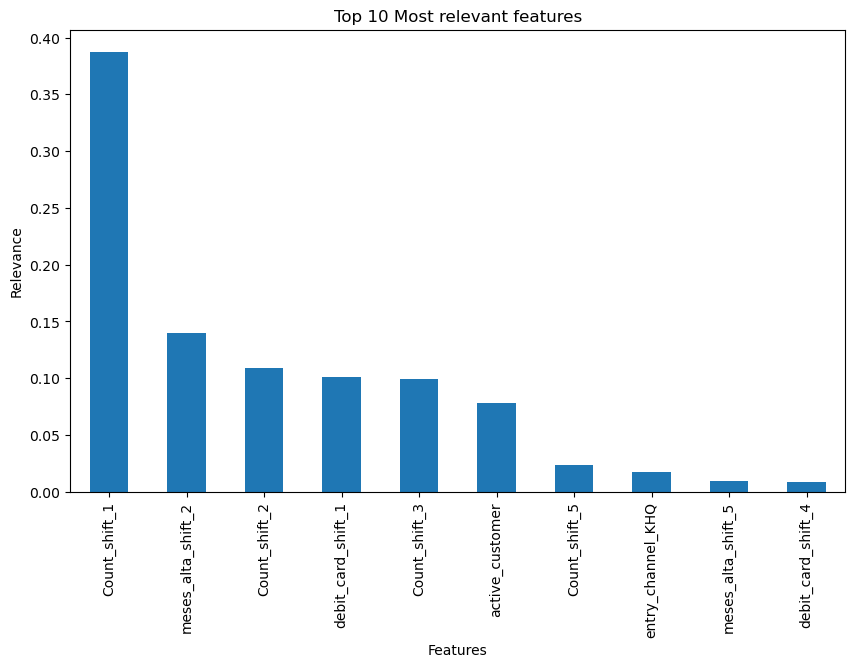

In [56]:
top_features = pd.Series(tree.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_features.plot(kind='bar')
plt.title('Top 10 Most relevant features')
plt.xlabel('Features')
plt.ylabel('Relevance')
plt.show()

In [57]:
predicciones = tree.predict_proba(junio_pred)

In [58]:
predicciones

array([[7.27141511e-03, 9.76368371e-01, 1.63602141e-02],
       [7.27141511e-03, 9.76368371e-01, 1.63602141e-02],
       [6.71513193e-01, 3.28486807e-01, 0.00000000e+00],
       ...,
       [2.06565608e-04, 8.76267201e-01, 1.23526234e-01],
       [0.00000000e+00, 9.99090395e-01, 9.09604701e-04],
       [2.06565608e-04, 8.76267201e-01, 1.23526234e-01]])

In [59]:
# converting to df + naming cols, adding to df we used to predict earlier
predicciones_df = pd.DataFrame(predicciones, index=junio_datos.index, columns=['Cancellation_prob', 'Maintain_prob', 'Registration_prob'])
junio_pred_con_identif = pd.concat([junio_datos, predicciones_df], axis=1)

print(junio_pred_con_identif)

          pk_cid  Cancellation_prob  Maintain_prob  Registration_prob
5859968    16203           0.007271       0.976368           0.016360
5859969    16502           0.007271       0.976368           0.016360
5859970    17457           0.671513       0.328487           0.000000
5859971    17799           0.007271       0.976368           0.016360
5859972    17970           0.007271       0.976368           0.016360
...          ...                ...            ...                ...
6204667  1553456           0.000207       0.876267           0.123526
6204668  1553541           0.000207       0.876267           0.123526
6204669  1553559           0.000207       0.876267           0.123526
6204670  1553565           0.000000       0.999090           0.000910
6204671  1553571           0.000207       0.876267           0.123526

[344704 rows x 4 columns]


We are going to send emails to all those who have a probability greater than 30% of subscribing to the product next month. These customers will be the ones to whom we send personalized advertisements.

In [61]:
junio_pred_con_identif.query('Registration_prob>0.3').shape
#junio_pred_con_identif.to_csv('predicciones_debit.csv')

(2732, 4)